In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2
import os
import time

### Visual Tracker Benchmark
http://www.visual-tracking.net

The publisher of this dataset has tagged the sequences with 11 attributes, where each represents a challenging aspect in visual tracking:

**IV**: Illumination Variation - the illumination in the target region is significantly changed. <br>
**SV**: Scale Variation - the ratio of the bounding boxes of the first frame and the current frame is out of the range ts, ts > 1 (ts=2). <br>
**OCC**: Occlusion - the target is partially or fully occluded. <br>
**DEF**: Deformation - non-rigid object deformation. <br>
**MB**: Motion Blur - the target region is blurred due to the motion of target or camera. <br>
**FM**: Fast Motion - the motion of the ground truth is larger than tm pixels (tm=20). <br>
**IPR**: In-Plane Rotation - the target rotates in the image plane. <br>
**OPR**: Out-of-Plane Rotation - the target rotates out of the image plane. <br>
**OV**: Out-of-View - some portion of the target leaves the view. <br>
**BC**: Background Clutters - the background near the target has the similar color or texture as the target. <br>
**LR**: Low Resolution - the number of pixels inside the ground-truth bounding box is less than tr (tr =400). <br>

In [2]:
attr_lst = ["IV", "SV", "OCC", "DEF", "MB", "FM", "IPR", "OPR", "OV", "BC", "LR"]

attr_txt = open('./attributes.txt', 'r')
attr_seq_lst = []
for attr_line in attr_txt.readlines():
    if attr_line != '\n':
        if attr_line[-1:] == '\n':
            attr_line = attr_line[:-1]
        attr_seq_lst.append(attr_line.split(', '))

# a list that shows each attribute and the corresponding sequences that have that challenging aspect
for i in range(len(attr_lst)):
    print( "{0}: {1} ...".format(attr_lst[i], ", ".join(attr_seq_lst[i][0:3])) )

IV: Basketball, Box, Car1 ...
SV: Biker, BlurBody, BlurCar2 ...
OCC: Basketball, Biker, Bird2 ...
DEF: Basketball, Bird1, Bird2 ...
MB: Biker, BlurBody, BlurCar1 ...
FM: Biker, Bird1, Bird2 ...
IPR: Bird2, BlurBody, BlurFace ...
OPR: Basketball, Biker, Bird2 ...
OV: Biker, Bird1, Board ...
BC: Basketball, Board, Bolt2 ...
LR: Biker, Car1, Freeman3 ...


These attributes will be used later in the project when comparing the performance of different visual trackers. Similar to the benchmark results shown on the Visual Tracker Benchmark website, a table of different trackers with their performance in each challenging aspect/attribute will be provided in the final report.

### Sequences

In [3]:
seq_lst = os.listdir('./sequences')
print("{} ...".format(", ".join(seq_lst[0:10])))
print("Total number of sequences: {}".format(len(seq_lst)))

Basketball, Biker, Bird1, Bird2, BlurBody, BlurCar1, BlurCar2, BlurCar3, BlurCar4, BlurFace ...
Total number of sequences: 98


In [4]:
def get_num_of_frames(seq_name):
    frames = []
    seq_img_folder_path = './sequences/' + seq_name + '/img/'
    seq_img_folder = os.listdir(seq_img_folder_path)
    for img_name in seq_img_folder:
        if img_name.endswith('.jpg'):
            frames.append(img_name)
    return len(frames)

def get_first_frame_path(seq_name):
    frame_path = ''
    seq_img_folder_path = './sequences/' + seq_name + '/img/'
    seq_img_folder = os.listdir(seq_img_folder_path)
    for img_name in seq_img_folder:
        if img_name.endswith('.jpg'):
            frame_path = os.path.join(seq_img_folder_path, img_name)
            break
    return frame_path

def get_frame_size(seq_name):
    width = 0
    height = 0
    first_frame = []
    seq_img_folder_path = './sequences/' + seq_name + '/img/'
    seq_img_folder = os.listdir(seq_img_folder_path)
    first_frame = cv2.imread(get_first_frame_path(seq_name))

    height, width, channel = first_frame.shape
    return width, height

In [5]:
df_seq_info = pd.DataFrame(0, columns=['num_of_frames', 'frame_width', 'frame_height']+attr_lst, index=seq_lst)

for seq_idx, seq_row in df_seq_info.iterrows():
    num_of_frames = get_num_of_frames(seq_idx)
    frame_width, frame_height = get_frame_size(seq_idx)
    df_seq_info.at[seq_idx, 'num_of_frames'] = num_of_frames
    df_seq_info.at[seq_idx, 'frame_width'] = frame_width
    df_seq_info.at[seq_idx, 'frame_height'] = frame_height
    for attr_idx in range(len(attr_lst)):
        if seq_idx in attr_seq_lst[attr_idx]:
            df_seq_info.at[seq_idx, attr_lst[attr_idx]] = 1
    
df_seq_info

,num_of_frames,frame_width,frame_height,IV,SV,OCC,DEF,MB,FM,IPR,OPR,OV,BC,LR
Basketball,725,576,432,1,0,1,1,0,0,0,1,0,1,0
Biker,142,640,360,0,1,1,0,1,1,0,1,1,0,1
Bird1,408,720,400,0,0,0,1,0,1,0,0,1,0,0
Bird2,99,720,400,0,0,1,1,0,1,1,1,0,0,0
BlurBody,334,640,480,0,1,0,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Twinnings,472,320,240,0,1,0,0,0,0,0,1,0,0,0
Vase,271,320,240,0,1,0,0,0,1,1,0,0,0,0
Walking,412,768,576,0,1,1,1,0,0,0,0,0,0,0
Walking2,500,384,288,0,1,1,0,0,0,0,0,0,0,1


In [6]:
# check if there are any sequences with all zero attributes
df_seq_info.loc[(df_seq_info[attr_lst]==0).all(axis=1)]

,num_of_frames,frame_width,frame_height,IV,SV,OCC,DEF,MB,FM,IPR,OPR,OV,BC,LR


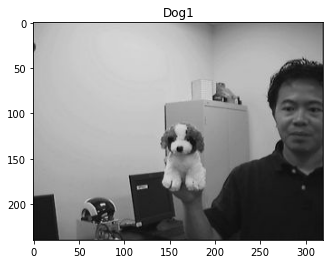

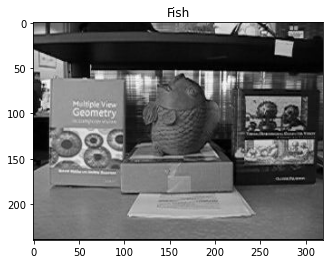

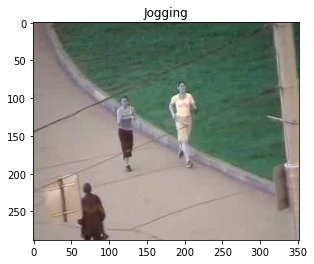

In [7]:
# show first frame of 3 sequence random sequences Dog1, Fish, and Jogging
temp_seq_lst = ['Dog1', 'Fish', 'Jogging'] # for demonstration purposes only
for seq_idx in range(len(temp_seq_lst)):
    img = cv2.imread(get_first_frame_path(temp_seq_lst[seq_idx]))
    plt.title(temp_seq_lst[seq_idx])
    plt.imshow(img)
    plt.show()

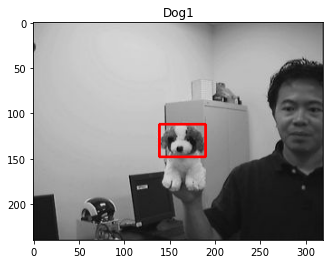

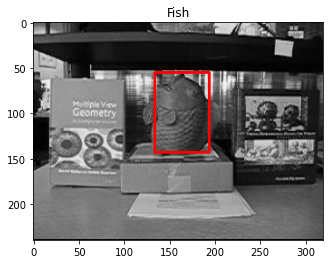

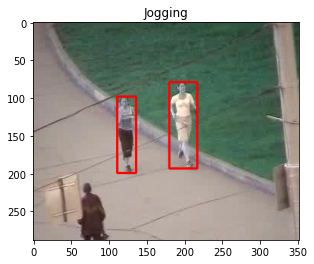

In [8]:
# show their first frame with the ground truth rect that's also given in the Sequence folder
for seq_idx in range(len(temp_seq_lst)):
    img = cv2.imread(get_first_frame_path(temp_seq_lst[seq_idx]))
    box_lst = os.listdir(os.path.join('./sequences/', temp_seq_lst[seq_idx]))
    for box_idx in range(len(box_lst)):
        if box_lst[box_idx].startswith('groundtruth_rect'):
            box_in_first_frame = open(os.path.join('./sequences/', temp_seq_lst[seq_idx],
                                                   box_lst[box_idx]), "r").readline().strip().replace('\t', ',')
            box_temp_lst = box_in_first_frame.split(',')
            box_start_x = int(box_temp_lst[0])
            box_start_y = int(box_temp_lst[1])
            box_width = int(box_temp_lst[2])
            box_height = int(box_temp_lst[3])
            cv2.rectangle(img, (box_start_x, box_start_y), (box_start_x + box_width, box_start_y + box_height), 255, 2)
    plt.title(temp_seq_lst[seq_idx])
    plt.imshow(img)
    plt.show()

In [10]:
# make sure that the filenames of the sequence frames start from 0001 eg. 0001.jpg to 0500.jpg 

def change_frame_names(folder_path):
    img_num = 1
    lst_files = os.listdir(folder_path)
    for filename in lst_files:
        if filename.endswith('.jpg'):
            _, file_type = filename.split(".")
            str_num = str(img_num).zfill(4)  # str_num is 4 characters long with leading 0
            new_filename = str_num + "." + file_type
            os.rename(os.path.join(folder_path, filename),
                      os.path.join(folder_path, new_filename))
            img_num += 1
        
'''
for seq in seq_lst:
    change_frame_names("./sequences/" + seq + "/img/")
'''